# Bernstein-Vazirani Algorithm for N-qubits

In [1]:
#=============================================================================#
#                            Importing packages                               #
#=============================================================================#
import numpy as np
import random 
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.providers.ibmq import least_busy  
provider = IBMQ.load_account()
from qiskit.visualization import plot_histogram

In [4]:
#=============================================================================#
#                                  Functions                                  #
#=============================================================================#
def rand_key(p):
    '''
    Generate a random key of 'p' elements
    '''
    # Array that store the digits of secret number
    key1_array = np.array([])

    # Each digit is randomly generated
    for i in range(p):  
        temp = round(random.random()) # Gives you a binary number(either 0 or 1)
        # Append element to array
        key1_array  = np.append(key1_array,temp)
         
    return(key1_array)
 
# Driver Code
n = 4

secret_array = rand_key(n)
print("Desired array containing the secret number is: ", secret_array)


def oracle(n, secret_array): #[Case: Balanced or Constant, n: number of qubits]
    '''
    Inputs:
    -------
    param n: (int) Size of the secret number
    param secret_array: (List) Secret number
    Output:
    -------
    Oracle circuit that encapsulate our function.
    '''
    # The oracle contains n-qubits of the input plus
    # one extra qubit
    oracle_qc = QuantumCircuit(n+1)

    # Bernstein-Vazirani
    for i in range(n):
        if secret_array[i]==1:
            oracle_qc.cx(i, n)

    
    # New Gate: Black Box
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = 'Oracle'
    return oracle_gate


def BV_algorithm(n, case = "random"):
    BV_circuit = QuantumCircuit(n+1,n) # Inputs: n+1 ; Outputs: n

    # Apply Hadamard gate to each qubit:
    for qubit in range(n):
        BV_circuit.h(qubit)

    # Set up the output qubit:
    BV_circuit.x(n)
    BV_circuit.h(n)

    # Append the oracle gate:
    if case == "random":
        random = np.random.randint(2)
        if random == 0:
            case = "constant"
        else:
            case = "balanced"

    BV_oracle = oracle(n,secret_array)
    BV_circuit.append(BV_oracle, range(n+1))

    # Hadamard gate and measure:
    for i in range(n):
        BV_circuit.h(i)
        BV_circuit.measure(i,i) # Measure qubit 'i' 
                                # and store the result in bit 'i'
    
    return BV_circuit

Desired array containing the secret number is:  [0. 1. 1. 1.]


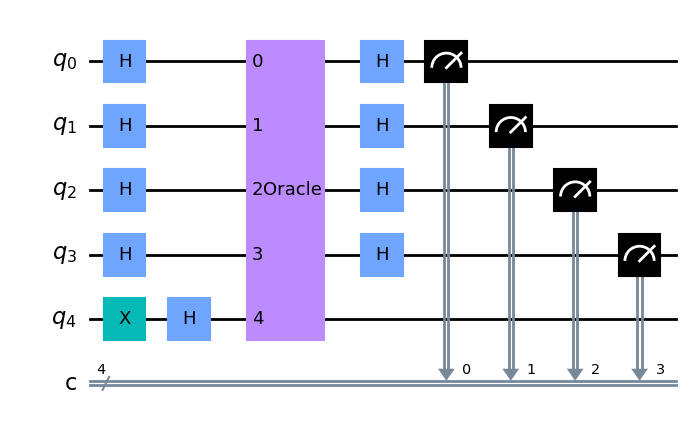

In [5]:
#=============================================================================#
#                               Circuit Plot                                  #
#=============================================================================#
BV_circuit = BV_algorithm(n)
BV_circuit.draw(output='mpl')

/opt/homebrew/Caskroom/miniforge/base/envs/qc-hackathon/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/qc-hackathon/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


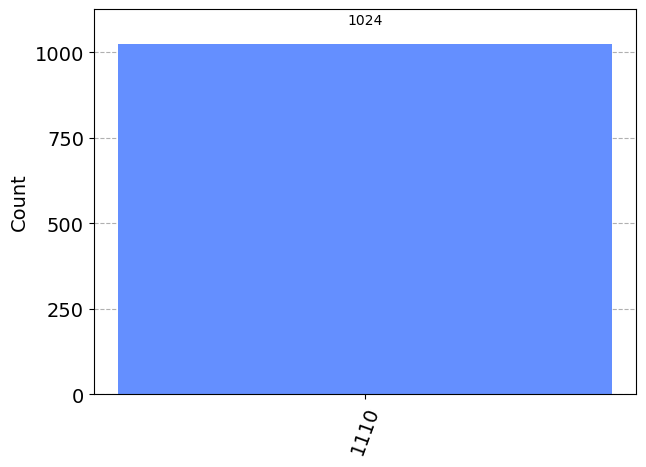

In [6]:
#=============================================================================#
#                Execution in Local Simulator (absense of noise)              #
#=============================================================================#
backend = Aer.get_backend('qasm_simulator')
job = execute(BV_circuit,backend,shots = 1024)
result = job.result()
counts = result.get_counts(BV_circuit)
plot_histogram(counts)

In [7]:
#=============================================================================#
#         Execution in real quantum machine via IBM Quantum Experience        #
#=============================================================================#
backend = least_busy(provider.backends(filters = lambda x: 
                                       x.configuration().n_qubits >= (n+1) and 
not x.configuration().simulator and x.status().operational == True))

print("least busy backend: ", backend)

BV_circuit = BV_algorithm(n,case = "balanced")
job = execute(BV_circuit,backend=backend,shots = 1024, optimization_level= 3)


least busy backend:  ibmq_belem


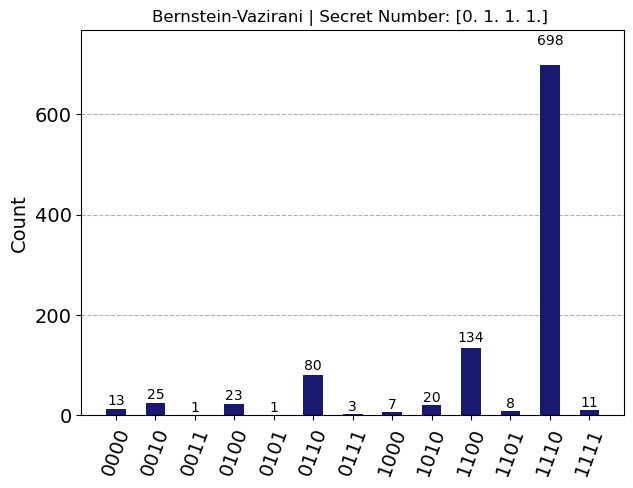

In [8]:
# Get the results and plot the histogram
result = job.result()
counts = result.get_counts()
plot_histogram(counts,color='midnightblue', title=
               "Bernstein-Vazirani | Secret Number: {} ".format(secret_array))